## **IMPORT LIBRARY**

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, Attention, Bidirectional, Input
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Bidirectional, LSTM, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

## **DATA**

In [ ]:
def get_crypto_data(crypto_symbol, start_date='2020-01-01', end_date='2024-10-01'):
    crypto_data = yf.download(crypto_symbol, start=start_date, end=end_date)
    return crypto_data[['Close']]

btc_data = get_crypto_data('BTC-USD')
eth_data = get_crypto_data('ETH-USD')
sol_data = get_crypto_data('SOL-USD')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## **EDA**

#### SAMPLE DATA

In [ ]:
btc_data.head()

Price,Close
Ticker,BTC-USD
Date,
2020-01-01 00:00:00+00:00,7200.174316
2020-01-02 00:00:00+00:00,6985.470215
2020-01-03 00:00:00+00:00,7344.884277
2020-01-04 00:00:00+00:00,7410.656738
2020-01-05 00:00:00+00:00,7411.317383


In [ ]:
eth_data.head()

Price,Close
Ticker,ETH-USD
Date,
2020-01-01 00:00:00+00:00,130.802002
2020-01-02 00:00:00+00:00,127.410179
2020-01-03 00:00:00+00:00,134.171707
2020-01-04 00:00:00+00:00,135.069366
2020-01-05 00:00:00+00:00,136.276779


In [ ]:
sol_data.head()

Price,Close
Ticker,SOL-USD
Date,
2020-04-10 00:00:00+00:00,0.951054
2020-04-11 00:00:00+00:00,0.776819
2020-04-12 00:00:00+00:00,0.882507
2020-04-13 00:00:00+00:00,0.777832
2020-04-14 00:00:00+00:00,0.661925


#### SUMMARY DATA

In [ ]:
btc_data.describe()

Price,Close
Ticker,BTC-USD
count,1735.000000
mean,33819.355456
std,18265.885449
min,4970.788086
25%,19293.700195
50%,30296.953125
75%,47101.230469
max,73083.500000


In [ ]:
eth_data.describe()

Price,Close
Ticker,ETH-USD
count,1735.000000
mean,1923.496368
std,1141.333484
min,110.605873
25%,1218.439880
50%,1839.089722
75%,2764.491333
max,4812.087402


In [ ]:
sol_data.describe()

Price,Close
Ticker,SOL-USD
count,1635.000000
mean,61.478863
std,62.180381
min,0.515273
25%,15.107450
50%,32.611038
75%,105.101379
max,258.934326


#### PLOT TIME SERIES

In [ ]:
def plot_time_series(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

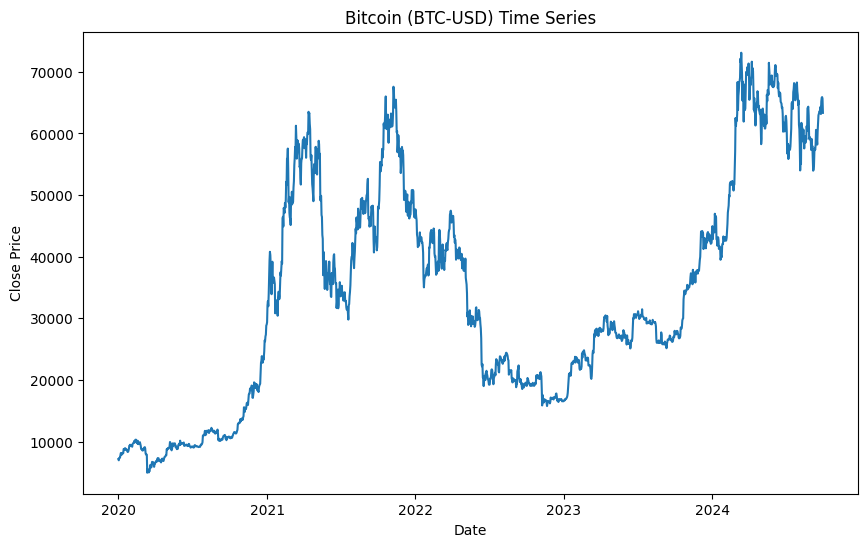

In [ ]:
plot_time_series(btc_data, 'Bitcoin (BTC-USD) Time Series')

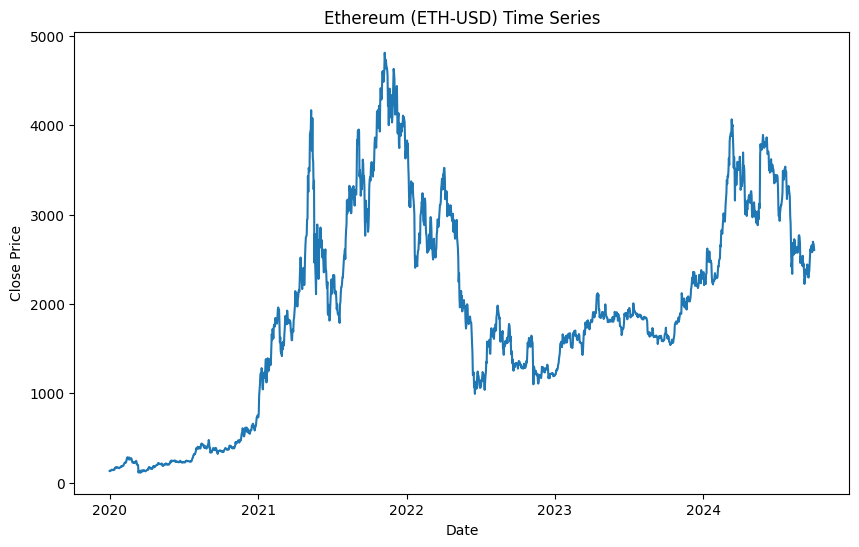

In [ ]:
plot_time_series(eth_data, 'Ethereum (ETH-USD) Time Series')

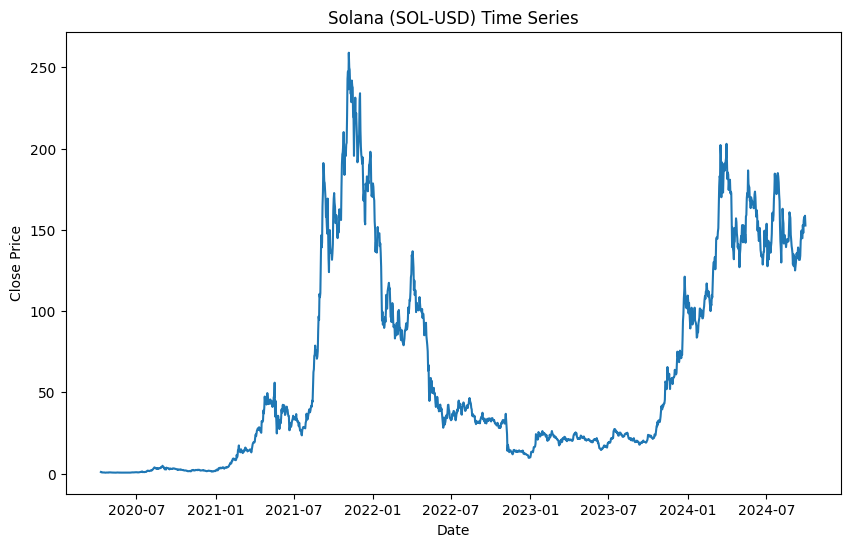

In [ ]:
plot_time_series(sol_data, 'Solana (SOL-USD) Time Series')

## **DATA PREPROCESS**

#### DATA TRANSFORM

In [ ]:
# Menghitung first-order log differencing pada data harga
def log_diff_transform(data):
    log_prices = np.log(data)  # Mengambil log dari harga
    log_diff = np.diff(log_prices, axis=0)  # Menghitung first-order differences
    return log_diff

#### WINDOWING

In [ ]:
# Fungsi untuk windowing data
def create_windowed_data(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Fungsi untuk menyiapkan data train, validasi, dan test dengan rolling window
def prepare_train_valid_test_data(data, window_size, num_splits, scale=True):
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    else:
        scaled_data = np.array(data)

    # Split data ke beberapa rolling window
    split_size = len(scaled_data) // num_splits
    X_train, y_train, X_valid, y_valid, X_test, y_test = [], [], [], [], [], []

    for i in range(num_splits):
        start_idx = i * split_size
        end_idx = start_idx + split_size

        # Windowing pada data train, validasi, dan test
        X_split, y_split = create_windowed_data(scaled_data[start_idx:end_idx], window_size)

        if i < num_splits - 2:  # Digunakan untuk training (split 1-3)
            X_train.append(X_split)
            y_train.append(y_split)
        elif i == num_splits - 2:  # Split 4 digunakan untuk validasi
            X_valid = X_split
            y_valid = y_split
        else:  # Split 5 digunakan untuk testing
            X_test = X_split
            y_test = y_split

    # Concatenate data training dari semua splits (1-3)
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Reshape untuk modeling (3 dimensi: samples, timesteps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_valid, y_valid, X_test, y_test, scaler

#### PREPROCESSING

In [ ]:
# Parameter Windowing
window_size = 10  # time steps
num_splits = 5    # Jumlah rolling windows

# Data untuk BTC, ETH, dan SOL
btc_close_prices = btc_data['Close'].values
eth_close_prices = eth_data['Close'].values
sol_close_prices = sol_data['Close'].values

In [ ]:
# Menyiapkan data train, validasi, dan test
X_btc_train, y_btc_train, X_btc_valid, y_btc_valid, X_btc_test, y_btc_test, scaler_btc = prepare_train_valid_test_data(btc_close_prices, window_size, num_splits)
X_eth_train, y_eth_train, X_eth_valid, y_eth_valid, X_eth_test, y_eth_test, scaler_eth = prepare_train_valid_test_data(eth_close_prices, window_size, num_splits)
X_sol_train, y_sol_train, X_sol_valid, y_sol_valid, X_sol_test, y_sol_test, scaler_sol = prepare_train_valid_test_data(sol_close_prices, window_size, num_splits)

#### PLOT LOG DIFF

In [ ]:
# Menghitung first-order log differencing untuk masing-masing
btc_log_diff = log_diff_transform(btc_close_prices)
eth_log_diff = log_diff_transform(eth_close_prices)
sol_log_diff = log_diff_transform(sol_close_prices)

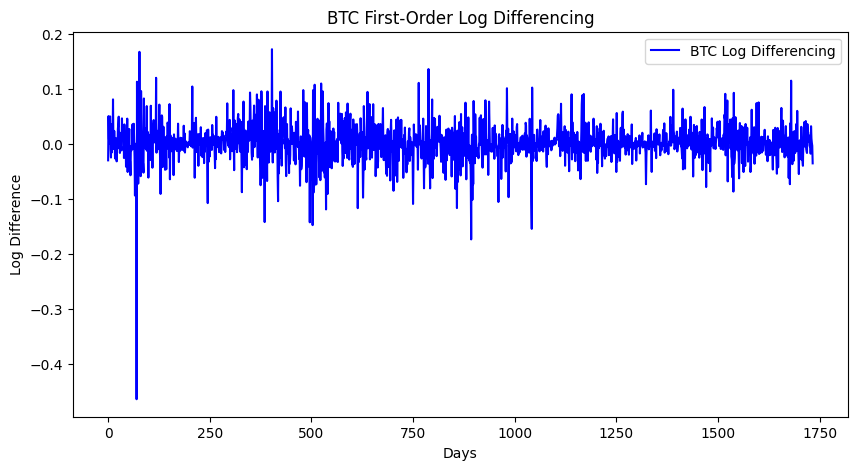

In [ ]:
# Plot BTC log differencing
plt.figure(figsize=(10, 5))
plt.plot(btc_log_diff, label='BTC Log Differencing', color='blue')
plt.title('BTC First-Order Log Differencing')
plt.xlabel('Days')
plt.ylabel('Log Difference')
plt.legend()
plt.show()

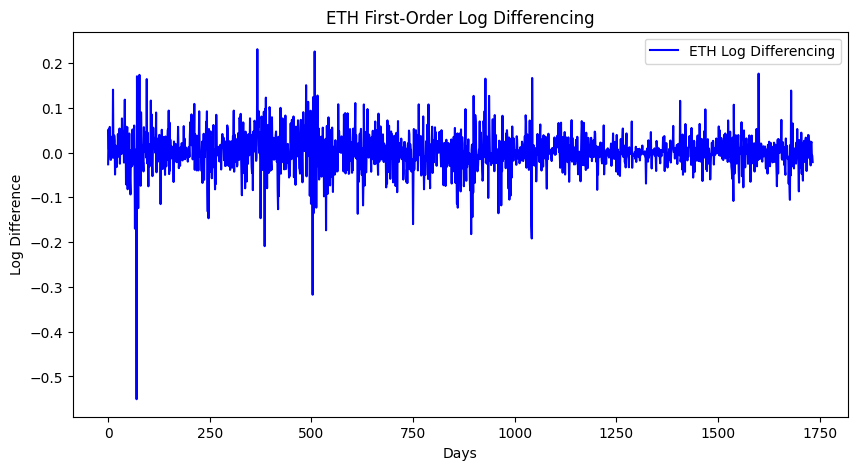

In [ ]:
# Plot ETH log differencing
plt.figure(figsize=(10, 5))
plt.plot(eth_log_diff, label='ETH Log Differencing', color='blue')
plt.title('ETH First-Order Log Differencing')
plt.xlabel('Days')
plt.ylabel('Log Difference')
plt.legend()
plt.show()

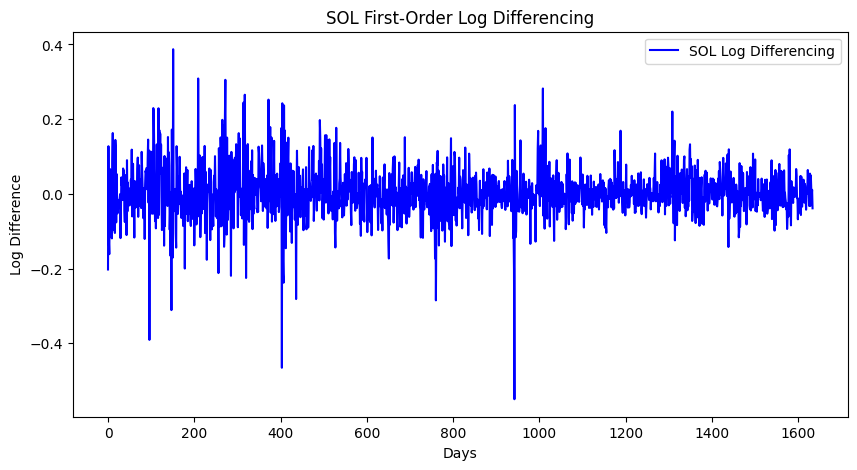

In [ ]:
# Plot SOL log differencing
plt.figure(figsize=(10, 5))
plt.plot(sol_log_diff, label='SOL Log Differencing', color='blue')
plt.title('SOL First-Order Log Differencing')
plt.xlabel('Days')
plt.ylabel('Log Difference')
plt.legend()
plt.show()

## **MODELLING**

In [ ]:
# Plot history MSE for training and validation
def plot_train_val_mse(history):
    train_mse = history.history['loss']
    val_mse = history.history['val_loss']
    epochs = range(1, len(train_mse) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mse, 'b', label='Training MSE')
    plt.plot(epochs, val_mse, 'r', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

#### LSTM

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()

    # Layer LSTM pertama
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # Layer LSTM kedua
    model.add(LSTM(64))
    #model.add(Dropout(0.2))

    # Fully connected layer (dense)
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))

    # Output layer untuk regresi (1 unit)
    model.add(Dense(1))

    # Optimizer Adam dengan learning rate 0.001
    optimizer = Adam(learning_rate=0.001)

    # Compile model dengan optimizer Adam dan loss function MSE
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

##### BTC

In [ ]:
lstm_model_1 = build_lstm_model((X_btc_train.shape[1], 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history_lstm_model_1 = lstm_model_1.fit(X_btc_train, y_btc_train, validation_data=(X_btc_valid, y_btc_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0681 - val_loss: 0.0014
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_loss: 3.3870e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 4.1851e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 3.3011e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 3.3551e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 3.0114e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 3.0524e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - val_loss: 2.8551e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015 - val_loss: 3.8026e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 4.3599e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 2.9792e-04
Epoch 12/50
32/32 ━━━━━

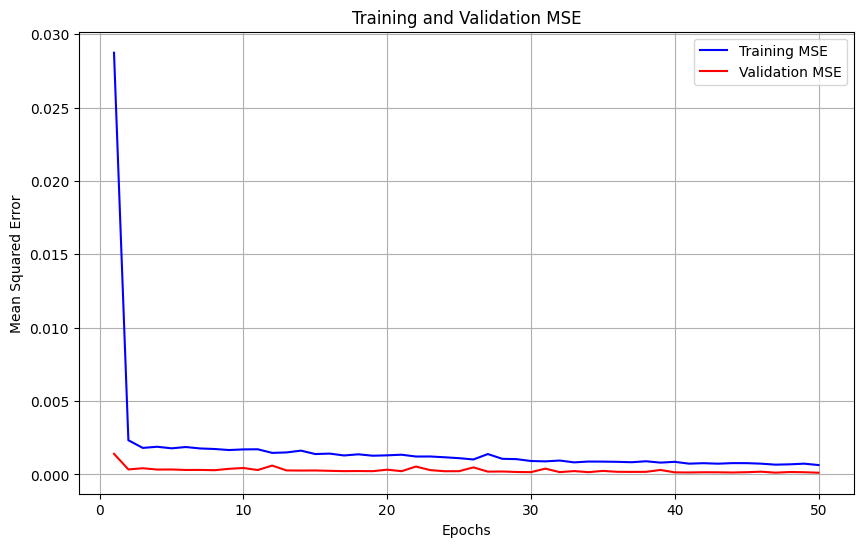

In [ ]:
plot_train_val_mse(history_lstm_model_1)

##### ETH

In [ ]:
lstm_model_2 = build_lstm_model((X_eth_train.shape[1], 1))

In [ ]:
history_lstm_model_2 = lstm_model_2.fit(X_eth_train, y_eth_train, validation_data=(X_eth_valid, y_eth_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0620 - val_loss: 2.9016e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 2.6342e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 2.5475e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024 - val_loss: 2.3202e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 2.3173e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 2.6331e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 7.5354e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0025 - val_loss: 4.0581e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023 - val_loss: 3.1397e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - val_loss: 3.8716e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 6.7335e-04
Epoch 12/50
32/32 ━

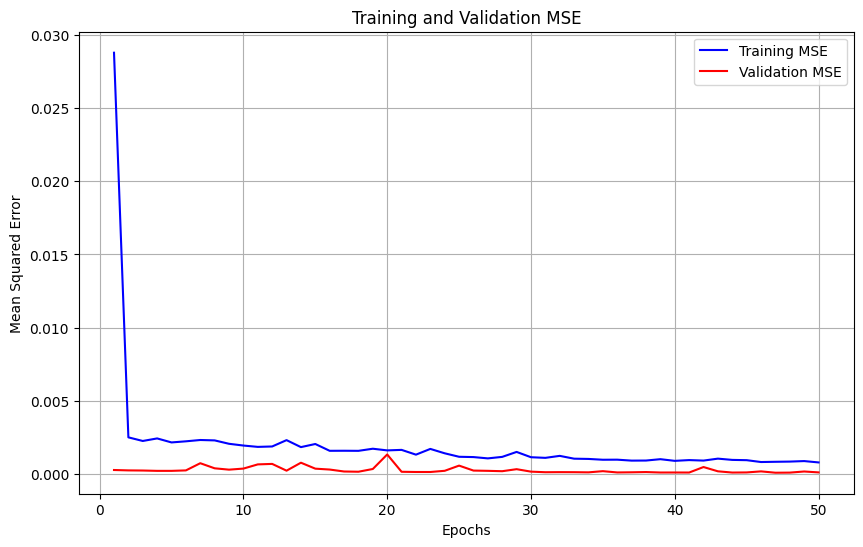

In [ ]:
plot_train_val_mse(history_lstm_model_2)

##### SOL

In [ ]:
lstm_model_3 = build_lstm_model((X_sol_train.shape[1], 1))

In [ ]:
history_lstm_model_3 = lstm_model_3.fit(X_sol_train, y_sol_train, validation_data=(X_sol_valid, y_sol_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0546 - val_loss: 9.3819e-05
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030 - val_loss: 9.9900e-05
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 3.0052e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 8.9906e-05
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0017 - val_loss: 1.0935e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0020 - val_loss: 8.5064e-05
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0019 - val_loss: 8.7279e-05
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 3.9528e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 1.9752e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 7.7830e-05
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 3.9262e-04
Epoch 12/50
30/30 ━

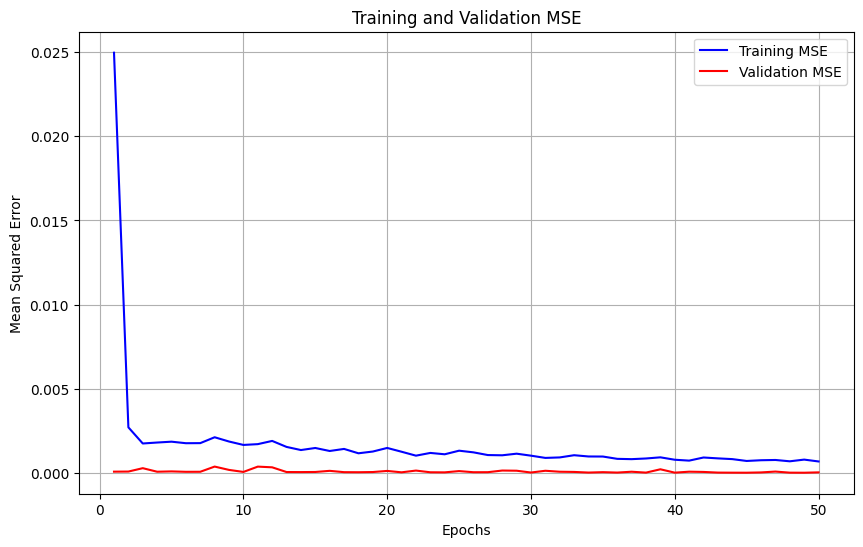

In [ ]:
plot_train_val_mse(history_lstm_model_3)

#### BiLSTM

In [ ]:
def build_bilstm_model(input_shape):
    model = Sequential()

    # Layer LSTM pertama (Bidirectional)
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))

    # Layer LSTM kedua (Bidirectional)
    model.add(Bidirectional(LSTM(64)))
    #model.add(Dropout(0.2))

    # Fully connected layer (dense)
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))

    # Output layer untuk regresi (1 unit)
    model.add(Dense(1))

    # Optimizer Adam dengan learning rate 0.001
    optimizer = Adam(learning_rate=0.001)

    # Compile model dengan optimizer Adam dan loss function MSE
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

##### BTC

In [ ]:
bilstm_model_1 = build_bilstm_model((X_btc_train.shape[1], 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history_bilstm_model_1 = bilstm_model_1.fit(X_btc_train, y_btc_train, validation_data=(X_btc_valid, y_btc_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0645 - val_loss: 0.0028
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0024 - val_loss: 2.8129e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0016 - val_loss: 2.6024e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - val_loss: 2.9197e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013 - val_loss: 3.8823e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014 - val_loss: 2.3836e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016 - val_loss: 2.2801e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - val_loss: 2.8323e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0012 - val_loss: 2.5565e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013 - val_loss: 3.9632e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0013 - val_loss: 2.0468e-04
Epoch 12/50
32/32 ━━━━━

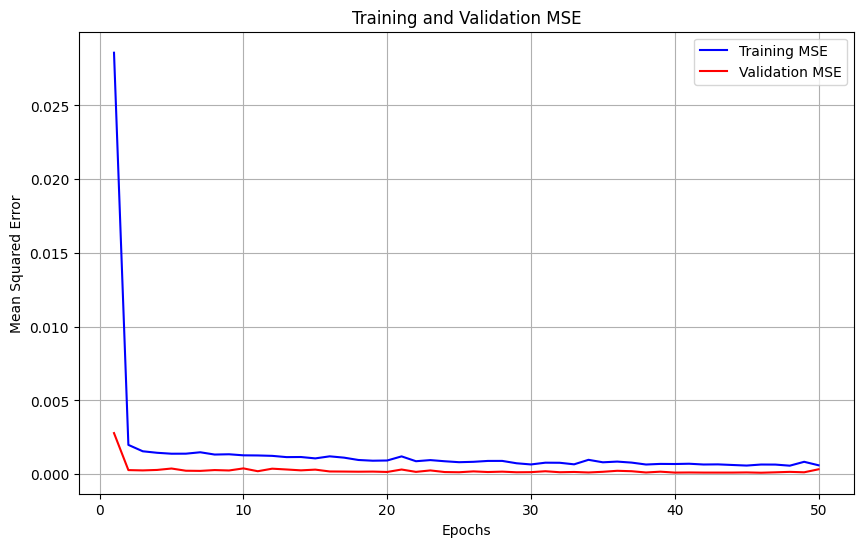

In [ ]:
plot_train_val_mse(history_bilstm_model_1)

##### ETH

In [ ]:
bilstm_model_2 = build_bilstm_model((X_eth_train.shape[1], 1))

In [ ]:
history_bilstm_model_2 = bilstm_model_2.fit(X_eth_train, y_eth_train, validation_data=(X_eth_valid, y_eth_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0601 - val_loss: 0.0017
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_loss: 9.7703e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - val_loss: 2.6054e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0018 - val_loss: 2.0374e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - val_loss: 3.3720e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0018 - val_loss: 2.2200e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0017 - val_loss: 1.8531e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014 - val_loss: 1.7566e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014 - val_loss: 1.7263e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014 - val_loss: 2.0684e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015 - val_loss: 1.7865e-04
Epoch 12/50
32/32 ━━━━━

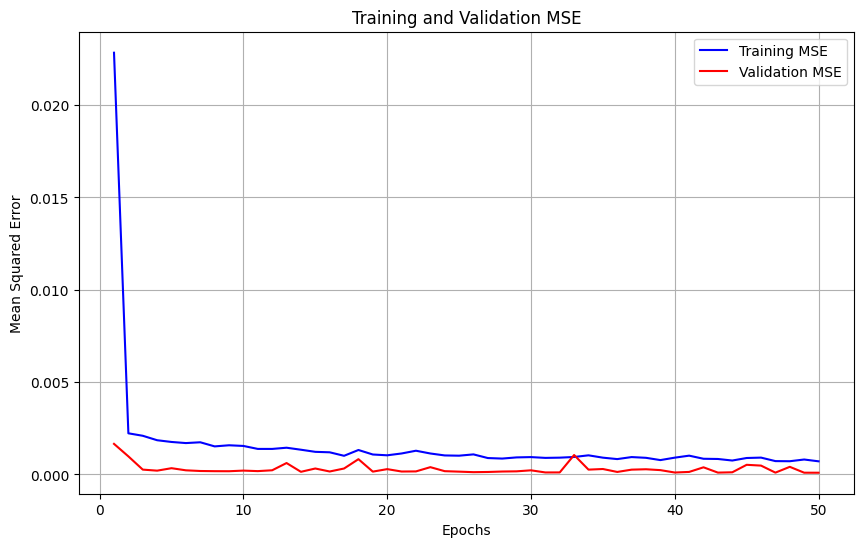

In [ ]:
plot_train_val_mse(history_bilstm_model_2)

##### SOL

In [ ]:
bilstm_model_3 = build_bilstm_model((X_sol_train.shape[1], 1))

In [ ]:
history_bilstm_model_3 = bilstm_model_3.fit(X_sol_train, y_sol_train, validation_data=(X_sol_valid, y_sol_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0350 - val_loss: 4.2838e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0017 - val_loss: 1.4602e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0018 - val_loss: 1.6661e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0015 - val_loss: 1.3735e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0014 - val_loss: 6.2122e-05
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013 - val_loss: 8.1935e-05
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013 - val_loss: 9.0800e-05
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0015 - val_loss: 5.3741e-05
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 1.3886e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 7.2107e-05
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 7.0200e-05
Epoch 12/50
30/30 

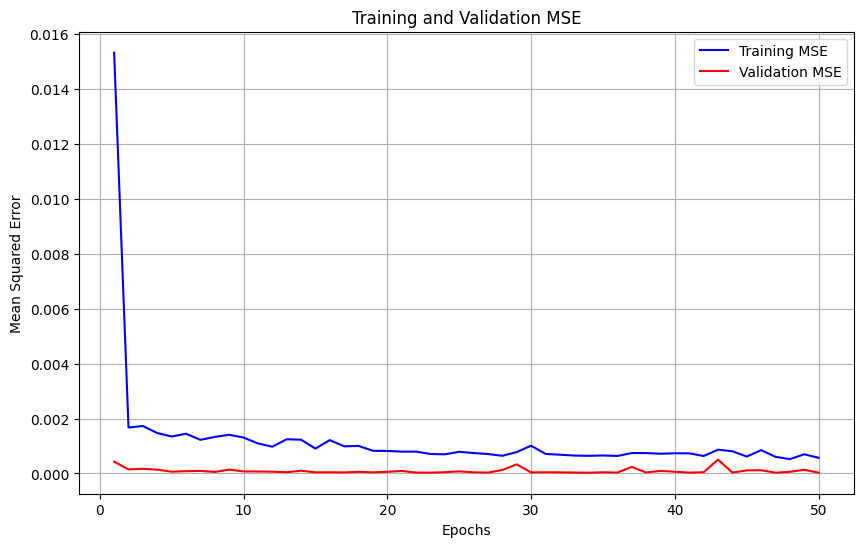

In [ ]:
plot_train_val_mse(history_bilstm_model_3)

#### CNN-BiLSTM

In [ ]:
def build_cnn_bilstm_model(input_shape):
    model = Sequential()

    # Layer Konvolusi Pertama
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    #model.add(Dropout(0.2))

    # Layer Konvolusi Kedua
    #model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.2))

    # Layer LSTM pertama (Bidirectional)
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))

    # Layer LSTM kedua (Bidirectional)
    model.add(Bidirectional(LSTM(64)))
    #model.add(Dropout(0.2))

    # Layer Dense untuk Output
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))

    # Output Layer untuk regresi (1 unit)
    model.add(Dense(1))

    # Optimizer Adam dengan learning rate 0.001
    optimizer = Adam(learning_rate=0.001)

    # Compile model dengan optimizer Adam dan loss function MSE
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

##### BTC

In [ ]:
cnn_bilstm_model_1 = build_cnn_bilstm_model((X_btc_train.shape[1], 1))

In [ ]:
history_cnn_bilstm_model_1 = cnn_bilstm_model_1.fit(X_btc_train, y_btc_train, validation_data=(X_btc_valid, y_btc_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0596 - val_loss: 8.1649e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0022 - val_loss: 4.4583e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - val_loss: 3.7413e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 2.8548e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 5.8693e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017 - val_loss: 3.0129e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - val_loss: 2.5955e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0016 - val_loss: 3.8212e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0015 - val_loss: 2.3820e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0017 - val_loss: 2.3141e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - val_loss: 2.3814e-04
Epoch 12/50
32/32 ━

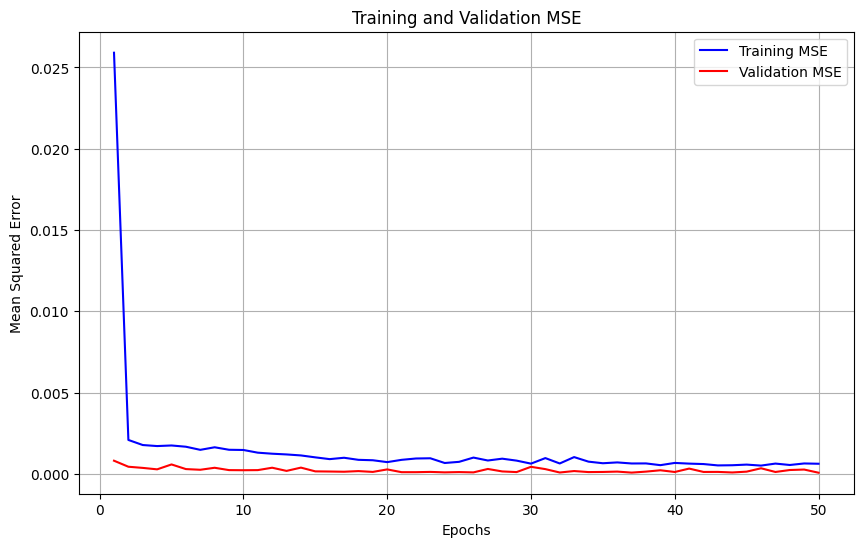

In [ ]:
plot_train_val_mse(history_cnn_bilstm_model_1)

##### ETH

In [ ]:
cnn_bilstm_model_2 = build_cnn_bilstm_model((X_eth_train.shape[1], 1))

In [ ]:
history_cnn_bilstm_model_2 = cnn_bilstm_model_2.fit(X_eth_train, y_eth_train, validation_data=(X_eth_valid, y_eth_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0670 - val_loss: 4.3020e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025 - val_loss: 3.9022e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023 - val_loss: 2.7134e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - val_loss: 3.8246e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - val_loss: 2.4975e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 2.5680e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0021 - val_loss: 3.6292e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0016 - val_loss: 2.3213e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0014 - val_loss: 1.8913e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0016 - val_loss: 1.8811e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 3.8350e-04
Epoch 12/50
32/32 ━

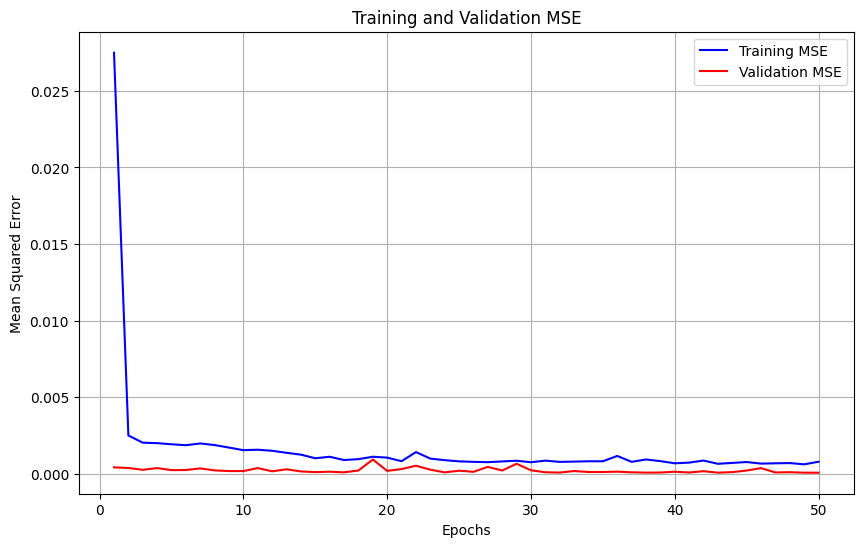

In [ ]:
plot_train_val_mse(history_cnn_bilstm_model_2)

##### SOL

In [ ]:
cnn_bilstm_model_3 = build_cnn_bilstm_model((X_sol_train.shape[1], 1))

In [ ]:
history_cnn_bilstm_model_3 = cnn_bilstm_model_3.fit(X_sol_train, y_sol_train, validation_data=(X_sol_valid, y_sol_valid),
                                            epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0318 - val_loss: 8.7792e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 2.3223e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0018 - val_loss: 1.2071e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0015 - val_loss: 9.8312e-05
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 1.1651e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 7.4292e-05
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016 - val_loss: 4.3408e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 5.7741e-05
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.8593e-04 - val_loss: 8.8449e-05
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.1418e-04 - val_loss: 9.6177e-05
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.5267e-04 - val_loss: 6.6046e-05
Epoch 1

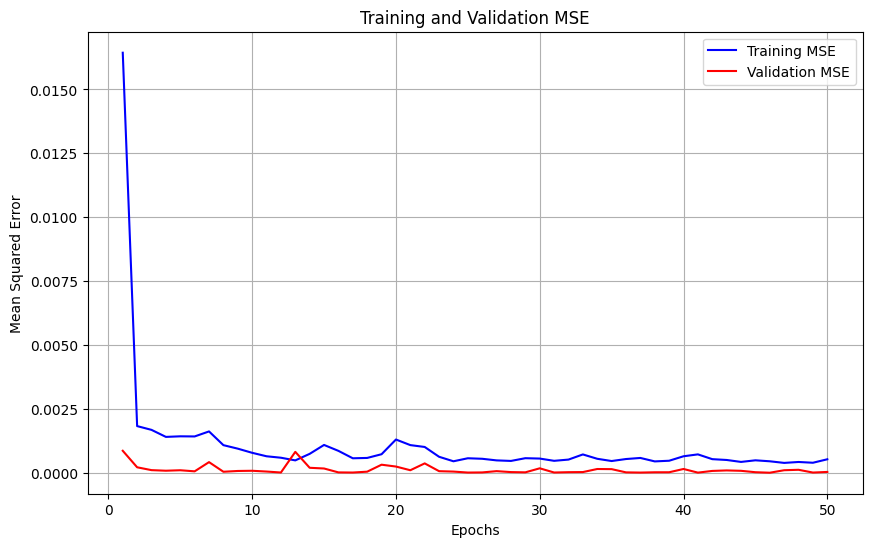

In [ ]:
plot_train_val_mse(history_cnn_bilstm_model_3)

## **EVALUATION**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def evaluate_model(model, X_test, y_test, scaler):
    # Memprediksi harga menggunakan model
    predicted = model.predict(X_test)

    # Pastikan dimensi prediksi sesuai untuk inverse_transform
    if predicted.ndim == 2:
        predicted_prices = scaler.inverse_transform(predicted)
    else:
        predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))

    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Menghitung metrik evaluasi
    mse = mean_squared_error(real_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100
    mae = mean_absolute_error(real_prices, predicted_prices)

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.plot(real_prices, color='red', label='Real Prices')
    plt.plot(predicted_prices, color='blue', label='Predicted Prices')
    plt.title(f'Predicted vs Real Prices\nRMSE: {rmse:.4f}, MAPE: {mape:.2f}%, MAE: {mae:.4f}')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    return rmse, mape, mae

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_da_model(model, X_test, y_test, scaler):
    # Memprediksi harga menggunakan model
    predicted = model.predict(X_test)

    # Pastikan dimensi prediksi sesuai untuk inverse_transform
    if predicted.ndim == 2:
        predicted_prices = scaler.inverse_transform(predicted)
    else:
        predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))

    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Hitung Direction Accuracy (DA)
    real_direction = np.where(np.diff(real_prices.flatten()) > 0, 1, 0)  # 1 untuk 'up', 0 untuk 'down'
    predicted_direction = np.where(np.diff(predicted_prices.flatten()) > 0, 1, 0)

    # Hanya ambil bagian yang valid untuk perhitungan DA
    valid_length = min(len(real_direction), len(predicted_direction))
    direction_accuracy = np.mean(real_direction[:valid_length] == predicted_direction[:valid_length]) * 100

    # Mencetak confusion matrix
    cm = confusion_matrix(real_direction[:valid_length], predicted_direction[:valid_length])
    print("Confusion Matrix:")
    print(cm) #(Down Up)

    # Visualisasi harga dan arah pergerakan
    plt.figure(figsize=(14, 7))

    # Plot harga aktual (garis merah)
    plt.plot(real_prices, color='red', label='Real Prices')

    # Plot harga prediksi (garis biru)
    plt.plot(predicted_prices, color='blue', label='Predicted Prices')

    # Menambahkan titik pergerakan untuk harga aktual
    for i in range(1, len(real_prices)):
        plt.scatter(i, real_prices[i], color='blue' if real_prices[i] > real_prices[i-1] else 'red')

    # Menambahkan titik pergerakan untuk harga prediksi
    for i in range(1, len(predicted_prices)):
        plt.scatter(i, predicted_prices[i], color='blue' if predicted_prices[i] > predicted_prices[i-1] else 'red')

    # Penyesuaian grafik dan judul
    plt.title(f'Predicted vs Real Prices with Directions (Up/Down)\nDirection Accuracy (DA): {direction_accuracy:.2f}%')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return direction_accuracy

#### LSTM

##### BTC

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


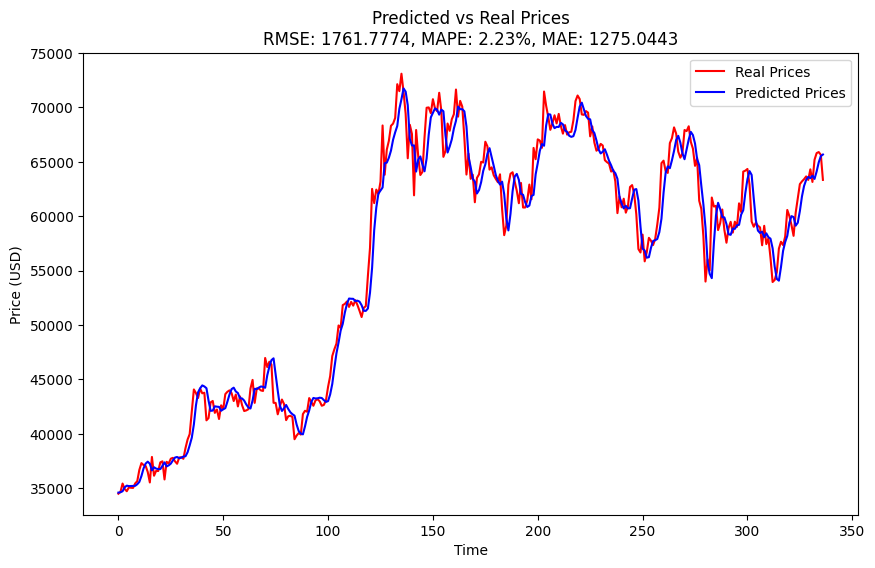

(1761.7773693377244, 2.230966977634583, 1275.0443017433233)

In [ ]:
evaluate_model(lstm_model_1, X_btc_test, y_btc_test, scaler_btc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[66 93]
 [87 90]]


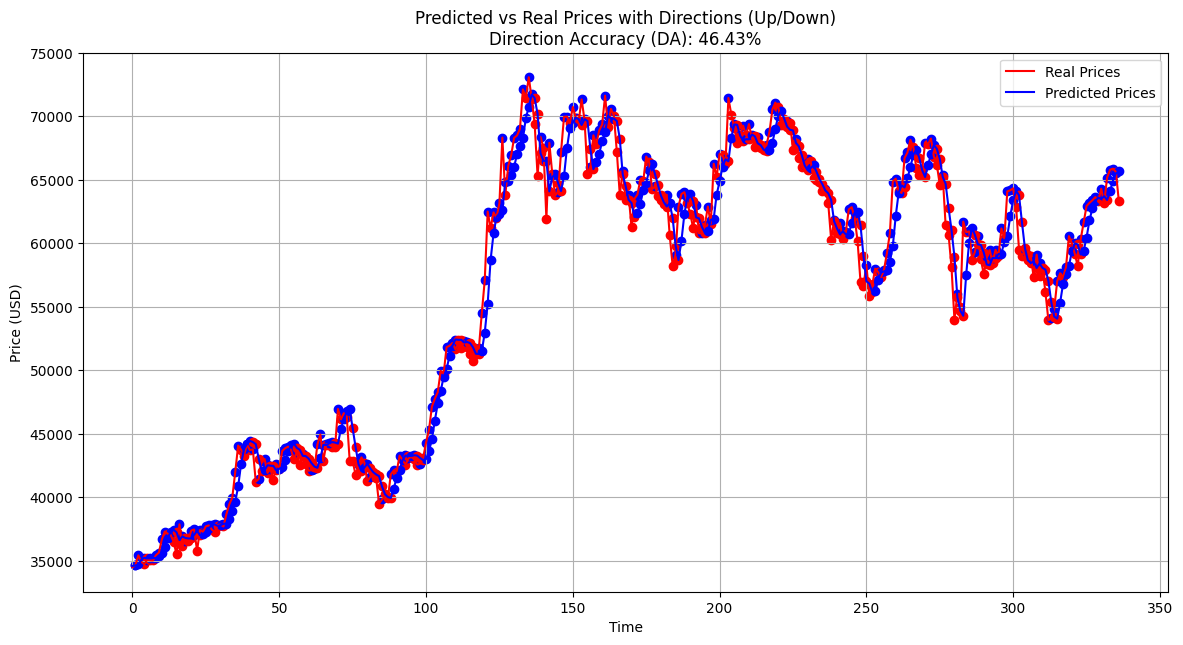

46.42857142857143

In [ ]:
evaluate_da_model(lstm_model_1, X_btc_test, y_btc_test, scaler_btc)

##### ETH

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


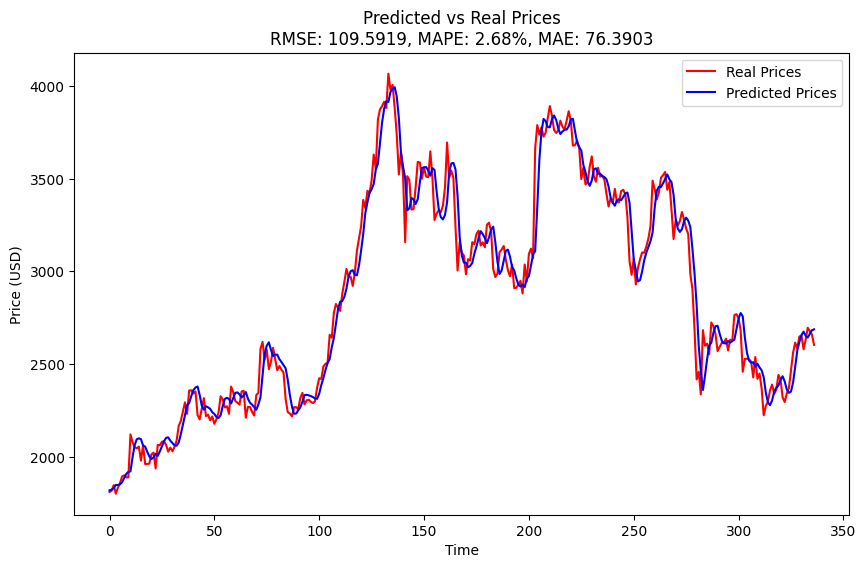

(109.59194882837396, 2.678831556760643, 76.39026168687408)

In [ ]:
evaluate_model(lstm_model_2, X_eth_test, y_eth_test, scaler_eth)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix:
[[64 93]
 [86 93]]


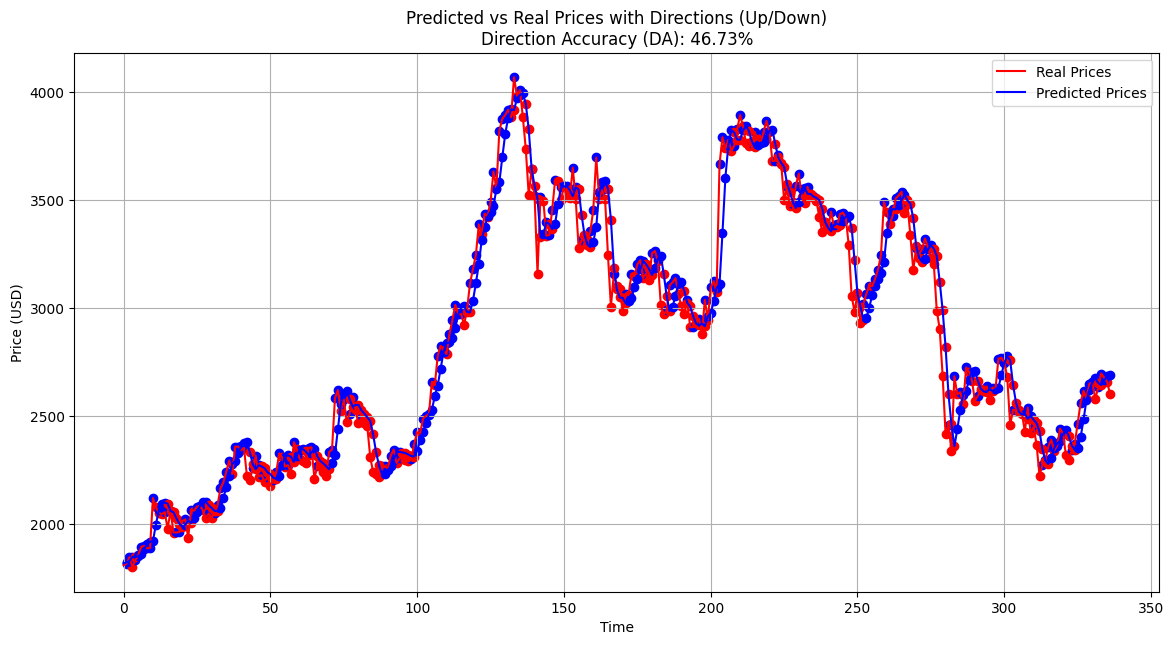

46.726190476190474

In [ ]:
evaluate_da_model(lstm_model_2, X_eth_test, y_eth_test, scaler_eth)

##### SOL

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


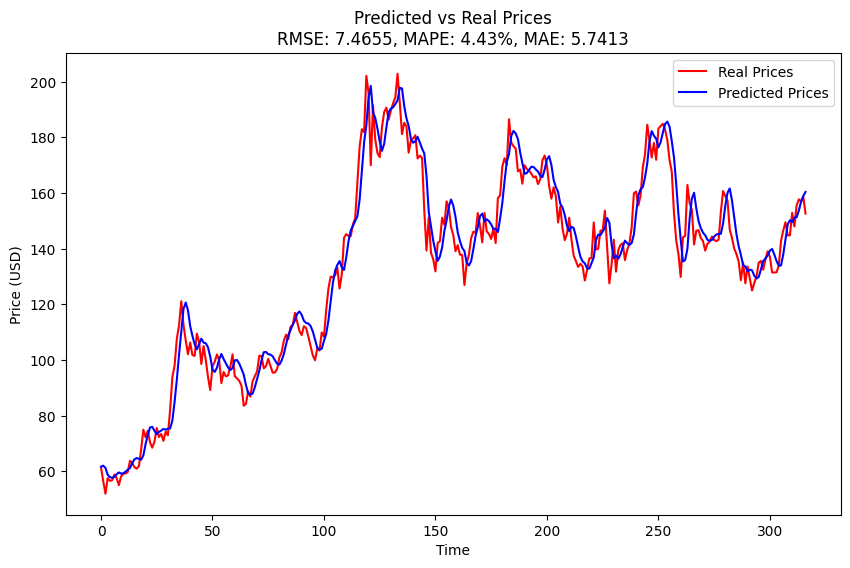

(7.465485329384288, 4.430162860097273, 5.741338808077743)

In [ ]:
evaluate_model(lstm_model_3, X_sol_test, y_sol_test, scaler_sol)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
[[75 79]
 [72 90]]


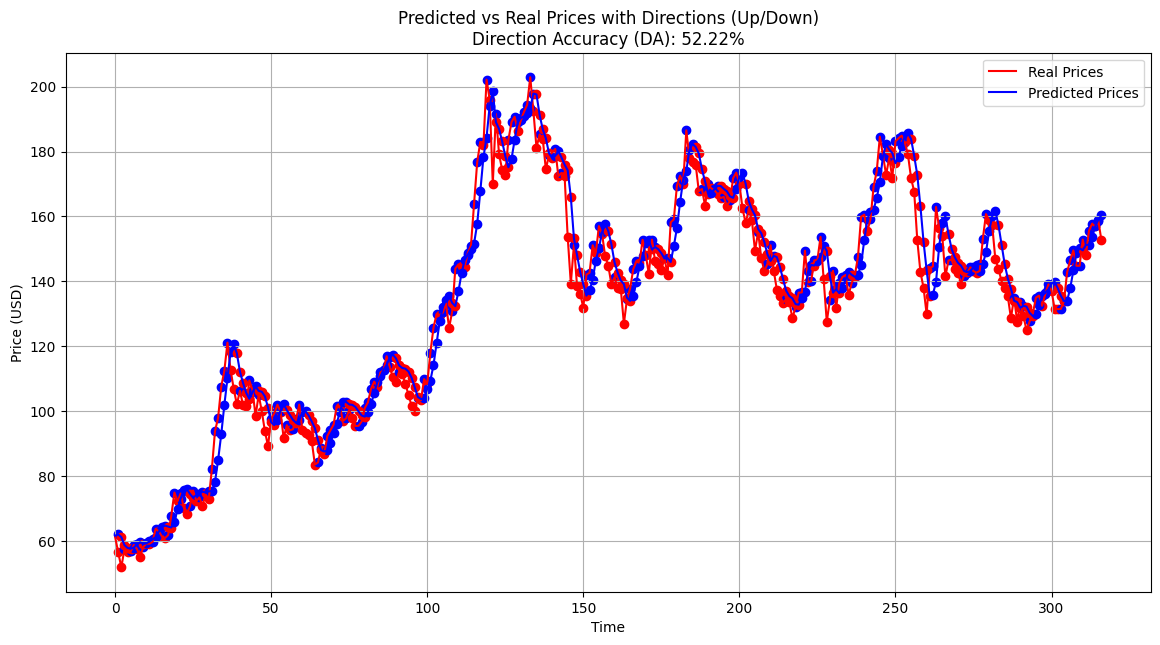

52.21518987341772

In [ ]:
evaluate_da_model(lstm_model_3, X_sol_test, y_sol_test, scaler_sol)

#### BiLSTM

##### BTC

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step


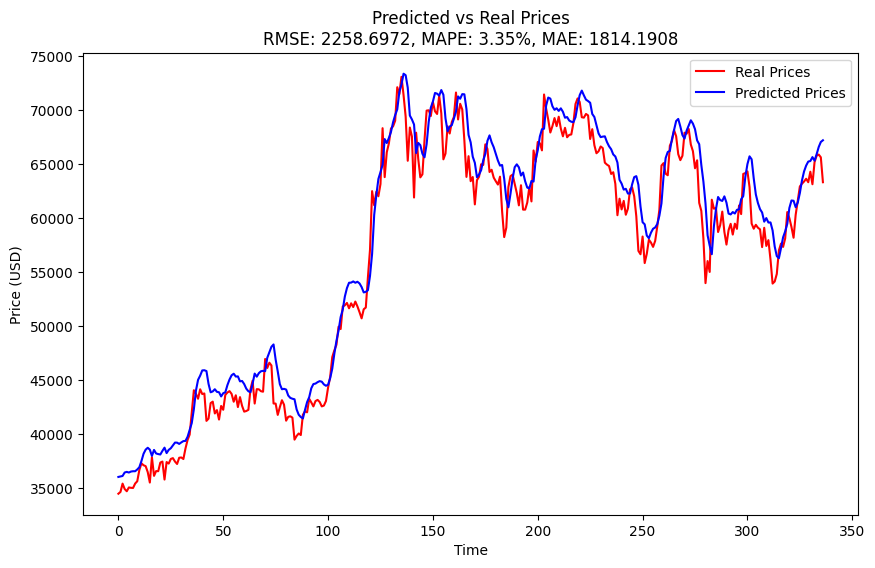

(2258.697221773252, 3.346275759664237, 1814.1908498701753)

In [ ]:
evaluate_model(bilstm_model_1, X_btc_test, y_btc_test, scaler_btc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Confusion Matrix:
[[63 96]
 [86 91]]


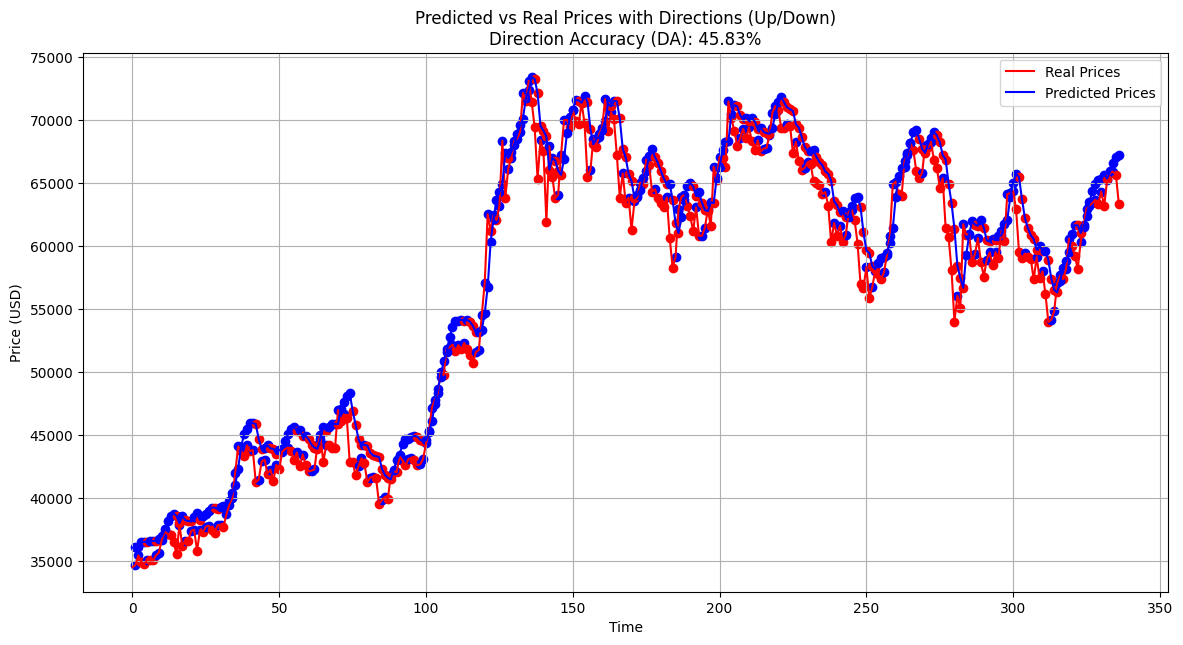

45.83333333333333

In [ ]:
evaluate_da_model(bilstm_model_1, X_btc_test, y_btc_test, scaler_btc)

##### ETH

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


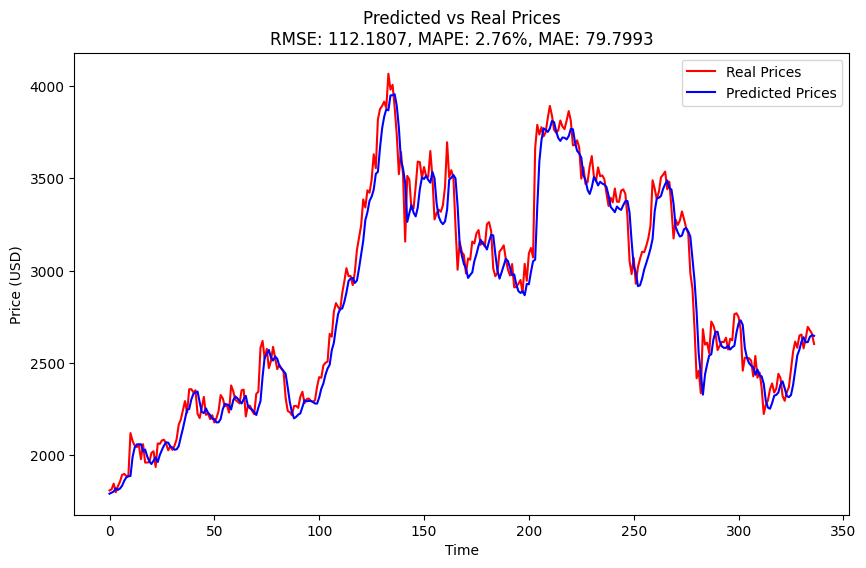

(112.18068362880474, 2.7555724707799913, 79.79925555220699)

In [ ]:
evaluate_model(bilstm_model_2, X_eth_test, y_eth_test, scaler_eth)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[71 86]
 [83 96]]


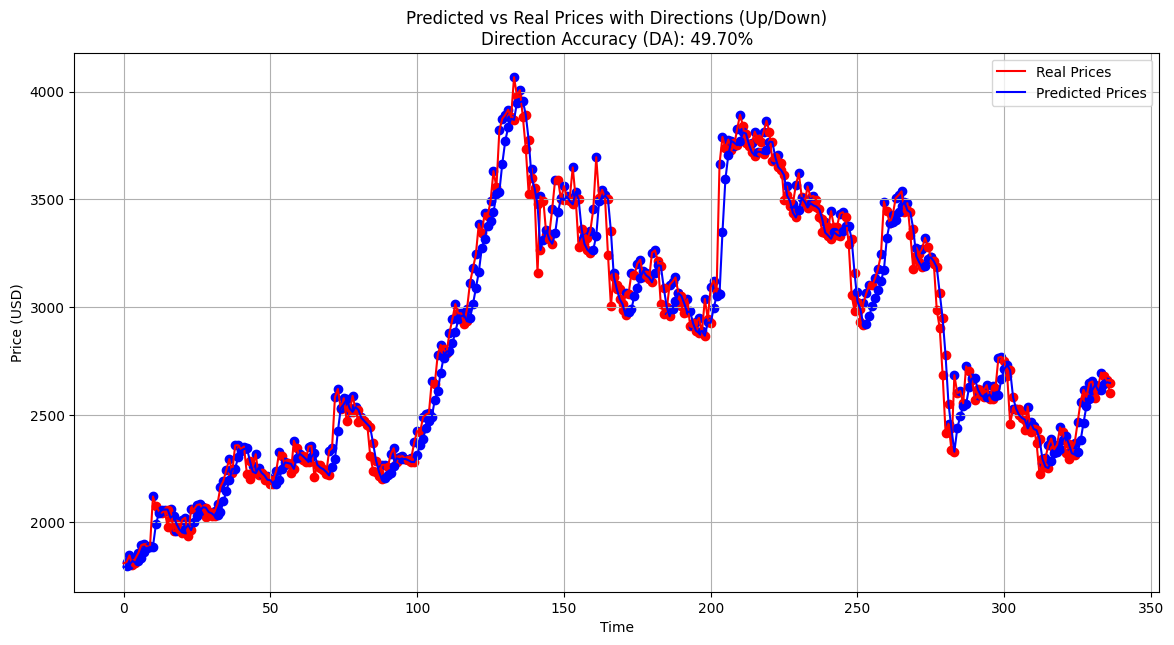

49.702380952380956

In [ ]:
evaluate_da_model(bilstm_model_2, X_eth_test, y_eth_test, scaler_eth)

##### SOL

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


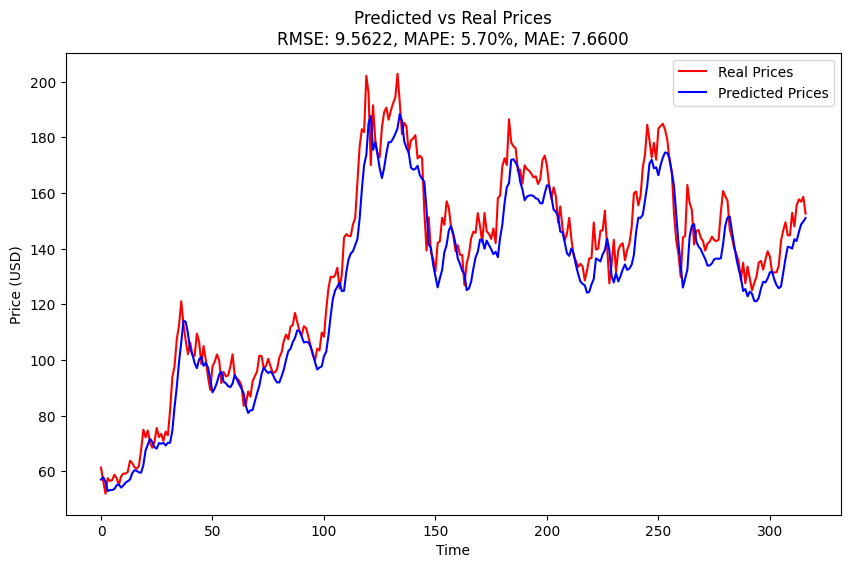

(9.562159842344512, 5.699720967012884, 7.6600224347520705)

In [ ]:
evaluate_model(bilstm_model_3, X_sol_test, y_sol_test, scaler_sol)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[73 81]
 [75 87]]


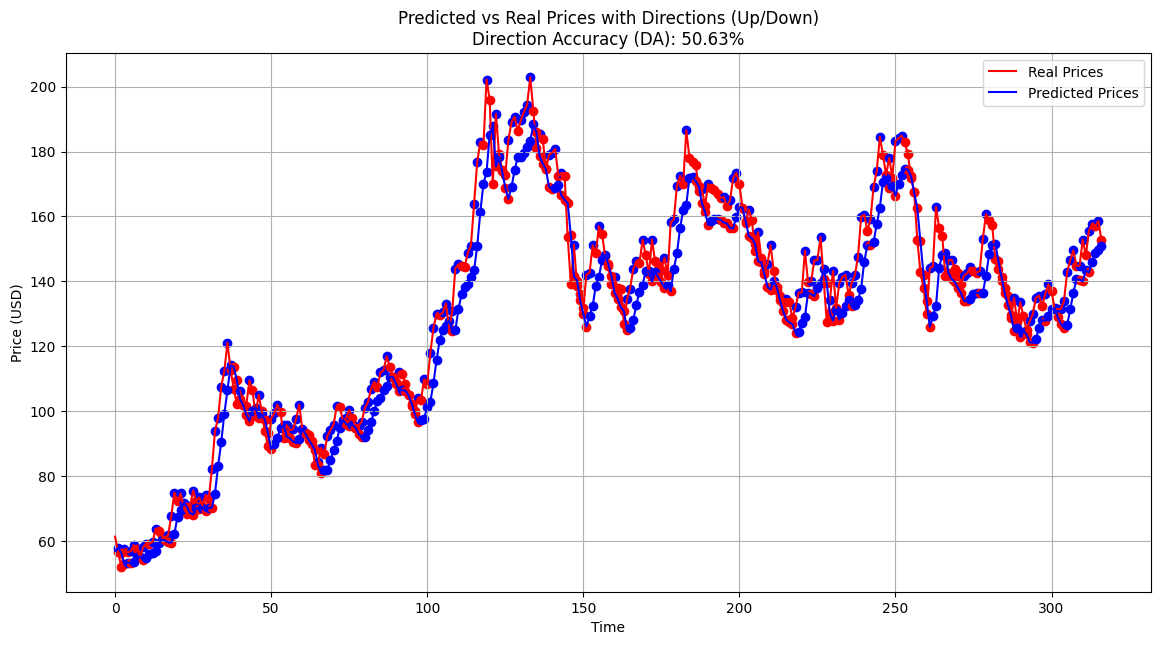

50.63291139240506

In [ ]:
evaluate_da_model(bilstm_model_3, X_sol_test, y_sol_test, scaler_sol)

#### CNN-BiLSTM

##### BTC

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


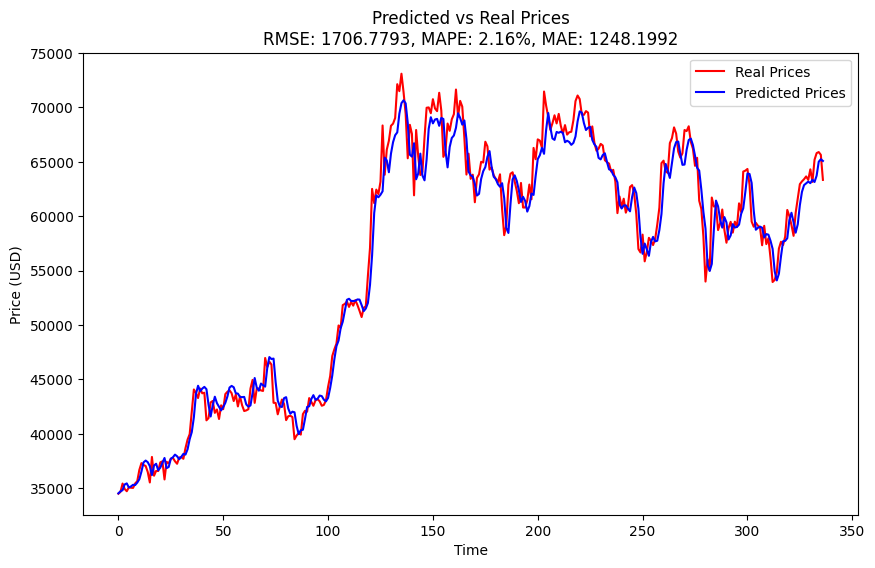

(1706.7792595519873, 2.161570210895183, 1248.1992303412467)

In [ ]:
evaluate_model(cnn_bilstm_model_1, X_btc_test, y_btc_test, scaler_btc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Confusion Matrix:
[[67 92]
 [85 92]]


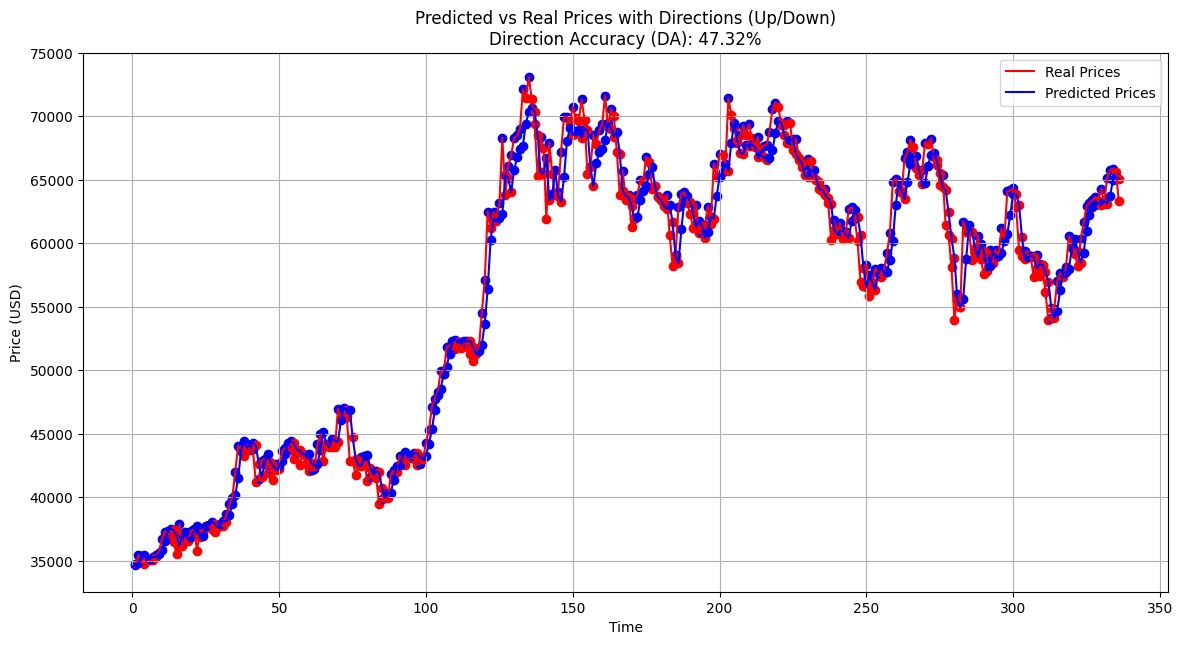

47.32142857142857

In [ ]:
evaluate_da_model(cnn_bilstm_model_1, X_btc_test, y_btc_test, scaler_btc)

##### ETH

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


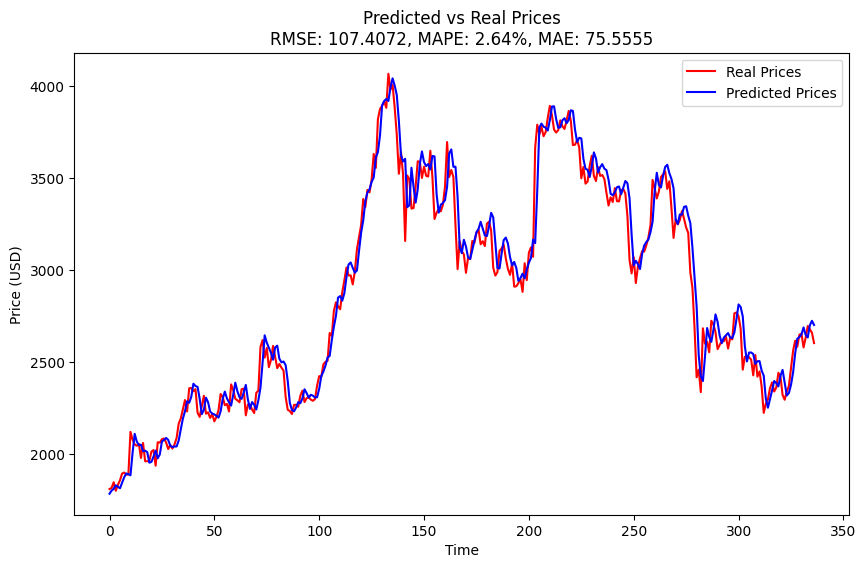

(107.40721832574002, 2.6443412319498756, 75.55549743833457)

In [ ]:
evaluate_model(cnn_bilstm_model_2, X_eth_test, y_eth_test, scaler_eth)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[68 89]
 [89 90]]


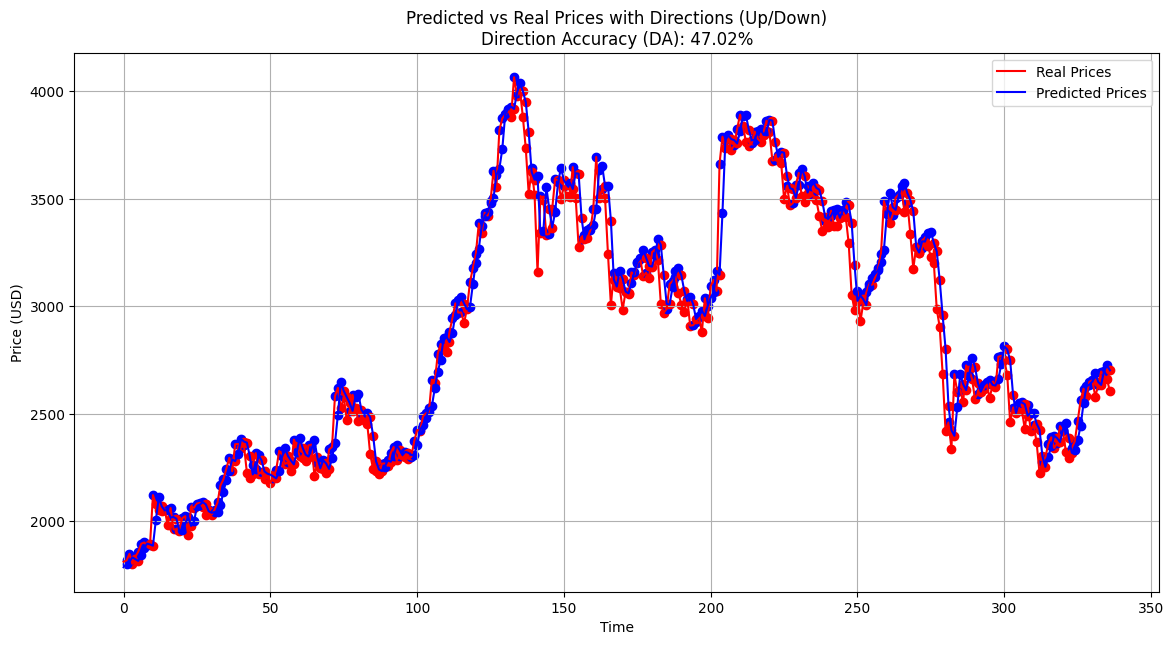

47.023809523809526

In [ ]:
evaluate_da_model(cnn_bilstm_model_2, X_eth_test, y_eth_test, scaler_eth)

##### SOL

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


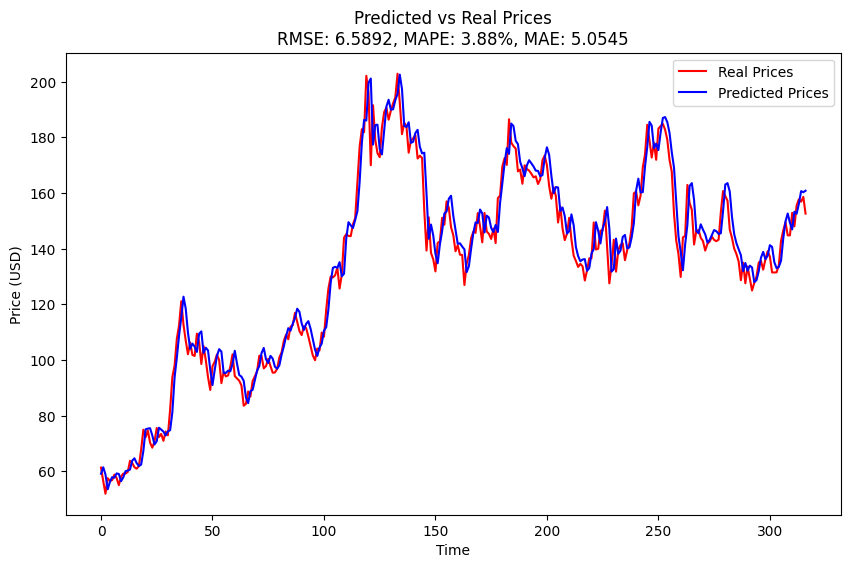

(6.589197669771549, 3.8774851906274934, 5.05449946069567)

In [ ]:
evaluate_model(cnn_bilstm_model_3, X_sol_test, y_sol_test, scaler_sol)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
[[73 81]
 [72 90]]


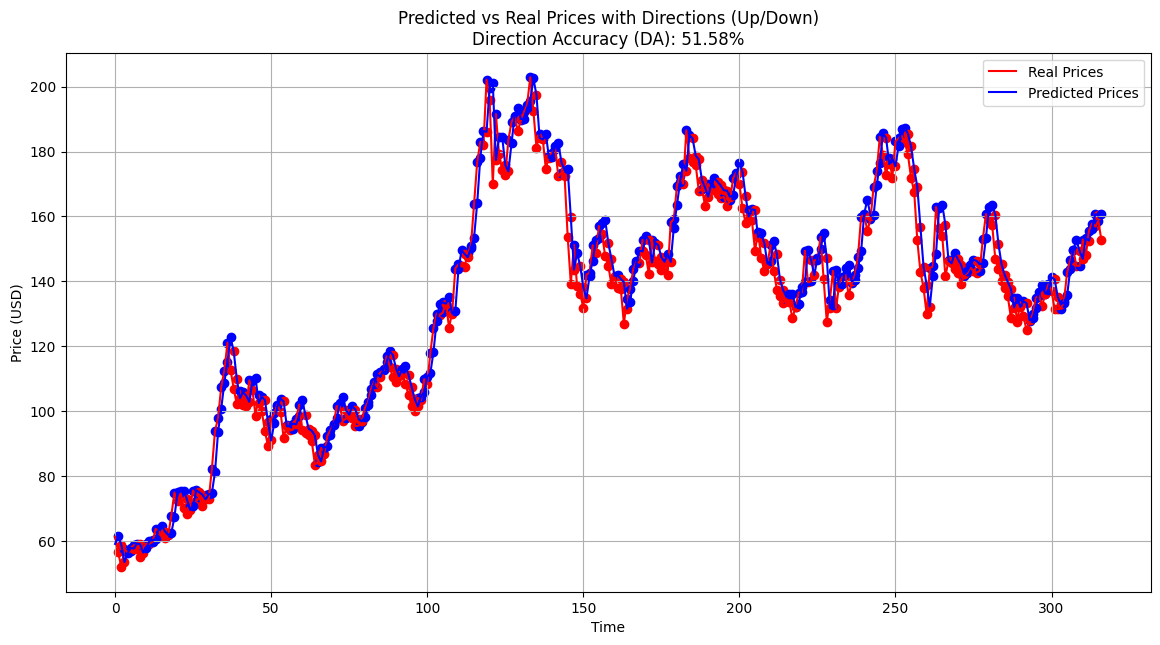

51.58227848101266

In [ ]:
evaluate_da_model(cnn_bilstm_model_3, X_sol_test, y_sol_test, scaler_sol)

## **FORECASTING**

In [ ]:
# Fungsi forecasting
def forecast_crypto(model, data, scaler, window_size, num_forecast_days):
    forecast_data = []
    last_window = data[-window_size:].values
    for _ in range(num_forecast_days):
        # Normalisasi input
        scaled_input = scaler.transform(last_window.reshape(-1, 1))
        scaled_input = np.reshape(scaled_input, (1, window_size, 1))

        # Melakukan prediksi
        predicted_scaled = model.predict(scaled_input)[0][0]

        # Inverse transform untuk mendapatkan nilai prediksi sebenarnya
        predicted_value = scaler.inverse_transform(np.array([[predicted_scaled]]))[0][0]
        forecast_data.append(predicted_value)

        # Memperbarui window input untuk prediksi selanjutnya
        last_window = np.append(last_window[1:], predicted_value)

    # Membuat DataFrame untuk hasil forecasting
    forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(1), periods=num_forecast_days)
    forecast_df = pd.DataFrame({'Forecast': forecast_data}, index=forecast_dates)

    return forecast_df

In [ ]:
# Jumlah hari yang akan diprediksi ke depan
forecast_days = [1, 7, 30]  # Forecast 1 hari, 7 hari, dan 30 hari

# Melakukan forecasting untuk BTC
btc_forecast_1d = forecast_crypto(cnn_bilstm_model_1, btc_data['Close'], scaler_btc, window_size, forecast_days[0])
btc_forecast_7d = forecast_crypto(cnn_bilstm_model_1, btc_data['Close'], scaler_btc, window_size, forecast_days[1])
btc_forecast_30d = forecast_crypto(cnn_bilstm_model_1, btc_data['Close'], scaler_btc, window_size, forecast_days[2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [ ]:
# Ambil num_forecast_days terakhir dari data aktual untuk visualisasi
btc_last_actual_data = btc_data['Close'][-(window_size + max(forecast_days)):]

In [ ]:
# Fungsi untuk visualisasi hasil forecasting dengan informasi up/down
def plot_forecast_with_directions(actual_data, forecast_data, title):
    plt.figure(figsize=(12, 7))

    # Plot data aktual
    plt.plot(actual_data.index, actual_data, color='blue', label='Harga Historis')

    # Plot titik-titik up/down untuk data aktual
    for i in range(1, len(actual_data)):
        if actual_data.iloc[i].item() > actual_data.iloc[i - 1].item():
            plt.scatter(actual_data.index[i], actual_data.iloc[i], color='blue')  # 'up'
        elif actual_data.iloc[i].item() < actual_data.iloc[i - 1].item():
            plt.scatter(actual_data.index[i], actual_data.iloc[i], color='red')   # 'down'

    # Plot data forecast
    plt.plot(forecast_data.index, forecast_data['Forecast'], color='orange', label='Prediksi')

    # Plot titik-titik up/down untuk data forecast
    for i in range(1, len(forecast_data)):
        if forecast_data['Forecast'].iloc[i].item() > forecast_data['Forecast'].iloc[i - 1].item():
            plt.scatter(forecast_data.index[i], forecast_data['Forecast'].iloc[i], color='blue')  # 'up'
        elif forecast_data['Forecast'].iloc[i].item() < forecast_data['Forecast'].iloc[i - 1].item():
            plt.scatter(forecast_data.index[i], forecast_data['Forecast'].iloc[i], color='red')   # 'down'

    # Menentukan arah dari titik awal forecasting berdasarkan batas akhir data aktual
    last_actual_value = actual_data.iloc[-1].item()
    forecast_start_value = forecast_data['Forecast'].iloc[0].item()

    if forecast_start_value > last_actual_value:
        plt.scatter(forecast_data.index[0], forecast_start_value, color='blue')  # 'up'
    elif forecast_start_value < last_actual_value:
        plt.scatter(forecast_data.index[0], forecast_start_value, color='red')   # 'down'

    # Garis oranye dari batas akhir pengamatan hingga titik awal prediksi
    plt.plot([actual_data.index[-1], forecast_data.index[0]],
             [last_actual_value, forecast_start_value],
             color='orange', linestyle='-', linewidth=2)

    plt.axvline(x=actual_data.index[-1], color='gray', linestyle='--', label='Batas Data Aktual dan Prediksi')
    plt.title(title)
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

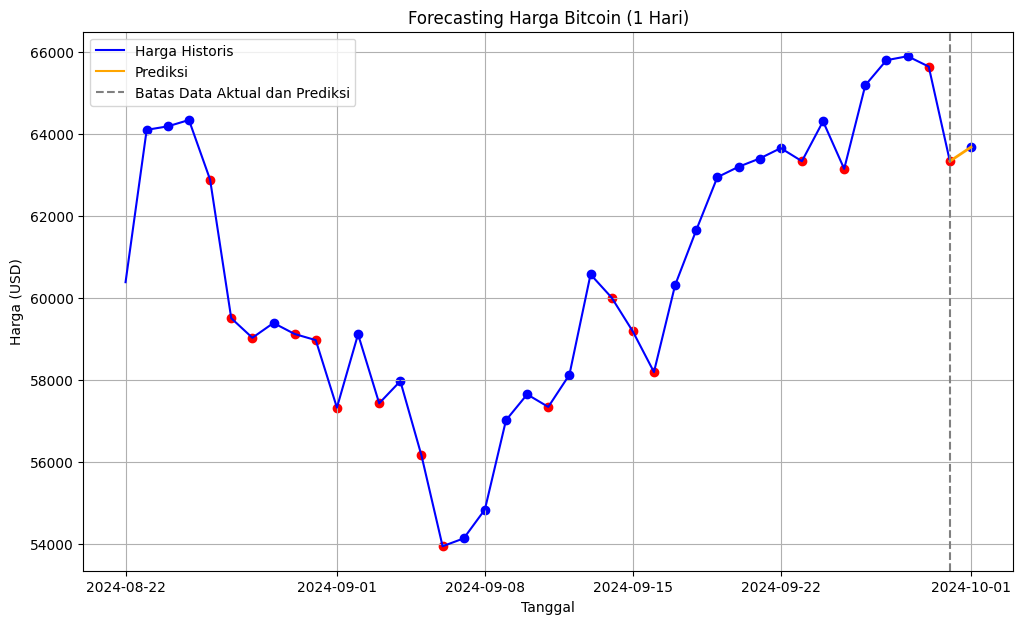

In [ ]:
# Visualisasi hasil forecasting untuk 1 hari
plot_forecast_with_directions(btc_last_actual_data, btc_forecast_1d, 'Forecasting Harga Bitcoin (1 Hari)')

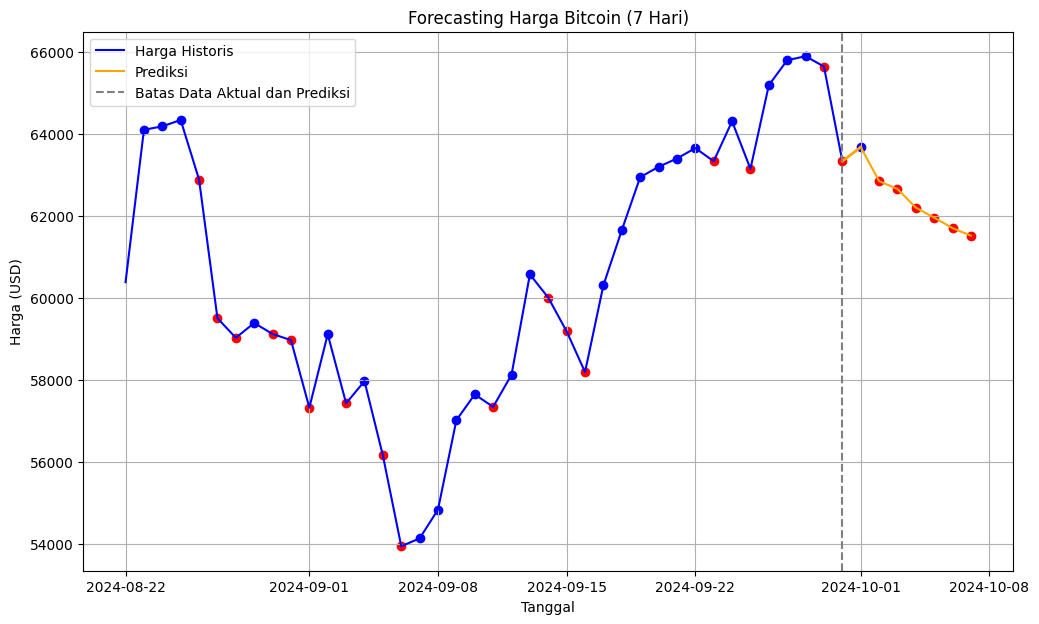

In [ ]:
# Visualisasi hasil forecasting untuk 7 hari
plot_forecast_with_directions(btc_last_actual_data, btc_forecast_7d, 'Forecasting Harga Bitcoin (7 Hari)')

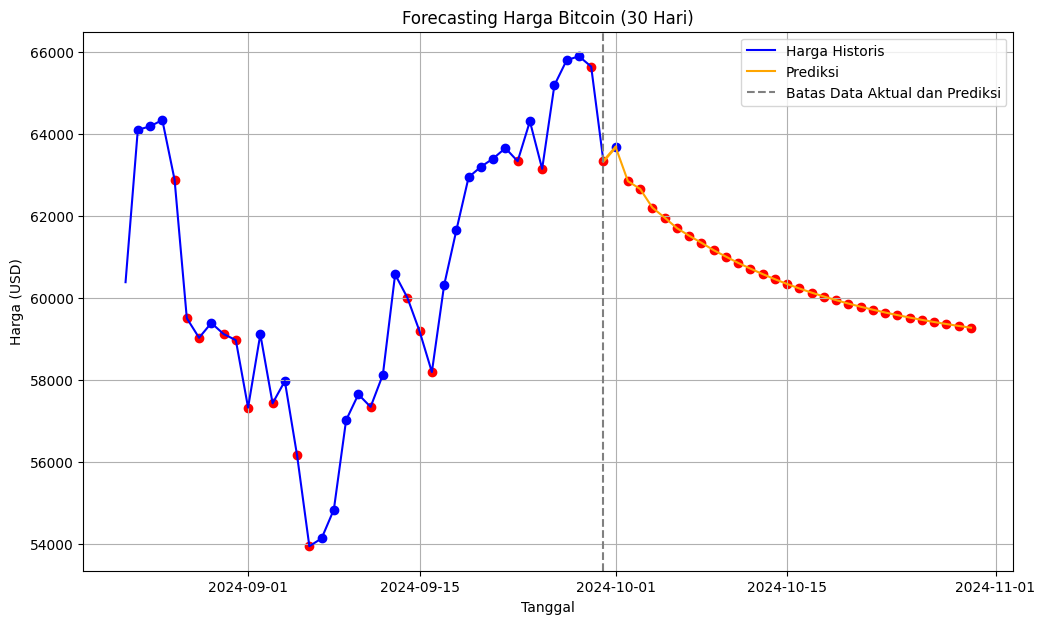

In [ ]:
# Visualisasi hasil forecasting untuk 30 hari
plot_forecast_with_directions(btc_last_actual_data, btc_forecast_30d, 'Forecasting Harga Bitcoin (30 Hari)')